In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.4)
from fastai.vision import * #Dataset

In [2]:
array = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
l=len(array)
for j in range(l):
  print(array[0])
  del array[0]
  print(array)

10
[20, 30, 40, 50, 60, 70, 80, 90, 100]
20
[30, 40, 50, 60, 70, 80, 90, 100]
30
[40, 50, 60, 70, 80, 90, 100]
40
[50, 60, 70, 80, 90, 100]
50
[60, 70, 80, 90, 100]
60
[70, 80, 90, 100]
70
[80, 90, 100]
80
[90, 100]
90
[100]
100
[]


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
!python --version

Python 3.7.13


In [5]:
import fastai; fastai.__version__

'1.0.61'

In [8]:
import copy

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/XRayDataSet/'
#THIS PATH SHOULD HAVE TWO FOLDERS: COVID and NON-COVID (w/e)
image_dataset = torchvision.datasets.ImageFolder(root=path)

In [9]:
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 630
    Root location: /content/drive/MyDrive/Colab Notebooks/XRayDataSet/


In [10]:
print(image_dataset.class_to_idx)

{'ANo_findings': 0, 'Covid-19': 1}


In [11]:
class_num_covid = image_dataset.class_to_idx['Covid-19']
class_num_not_covid = image_dataset.class_to_idx['ANo_findings']
print('Covid-19 Class: ', class_num_covid)
print('Not-Covid-19 Class: ', class_num_not_covid)

Covid-19 Class:  1
Not-Covid-19 Class:  0


In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [13]:
def conv_block(ni, nf, size=3, stride=1):
  for_pad = lambda s: s if s > 2 else 3
  return nn.Sequential(
      nn.Conv2d(ni, nf, kernel_size=size, stride=stride, padding=(for_pad(size) - 1)//2, bias=False), 
      nn.BatchNorm2d(nf),
      nn.LeakyReLU(negative_slope=0.1, inplace=True)
      )
        
def triple_conv(ni, nf):
  return nn.Sequential(
      conv_block(ni, nf),
      conv_block(nf, ni, size=1),  
      conv_block(ni, nf)
  )
        
def maxpooling():
  return nn.MaxPool2d(2, stride=2)

In [14]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.model = nn.Sequential(
          conv_block(3, 8),
          maxpooling(),
          conv_block(8, 16),
          maxpooling(),
          triple_conv(16, 32),
          maxpooling(),
          triple_conv(32, 64),
          maxpooling(),
          triple_conv(64, 128),
          maxpooling(),
          triple_conv(128, 256),
          conv_block(256, 128, size=1),
          conv_block(128, 256),
          conv_layer(256, 2),
          Flatten(),
          nn.Linear(338, 2),
          # nn.Sigmoid(),
          #Flatten(),
          # nn.Softmax(dim=1)   # get value between 0 and 1
      )
        
    def forward(self, x):
        z = self.model(x)
        return z

In [15]:
def c_mat(y_true, y_pred):
    _t = [int(1 if i[0] < i[1] else 0) for i in y_true]
    # print('y_pred: ' + str(y_pred))
    # _p = [int(1 if i[0] > 0 else 0) for i in y_pred]
    _p = [int(1 if i[0] < i[1] else 0) for i in y_pred]
    #print('t: ' + str(_t))
    #print('p: ' + str(_p))
    tn, fp, fn, tp = confusion_matrix(_t, _p, labels=[0, 1]).ravel()
    #print('tn: ' + str(tn), ' fp: ' + str(fp), ' fn: ' + str(fn), ' tp: ' + str(tp))
    # print('fp: ' + str(fp))
    # print('fn: ' + str(fn))
    # print('tp: ' + str(tp))
    return tn, fp, fn, tp

In [16]:
class Adam_Optimizer():
    
    def __init__(self, num_items,num_factors, beta_1=0.9, beta_2=0.99, gemma=3e-3, epsilon=1e-8):#0.003    #0.01
        """Initialize
        Args:
        num_items:  Total number of items in the data
        num_factors: Number of factors
        beta_1: hyper-parameter
        beta_2: hyper-parameter
        gemma: hyper-parameter
        epsilon: hyper-parameter
        """
        self.num_items = num_items
        self.num_factors = num_factors
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.gemma = gemma
        self.epsilon = epsilon
        
        self.m = np.zeros((self.num_items, self.num_factors))
        self.v = np.zeros((self.num_items, self.num_factors))
        self.t = 0
    
    # This method is used to calculate the gradient using Adam optimizer
    def optimize_gradients(self, gradients):
        
        self.t += 1
        
        self.m = (self.beta_1 * self.m) + (1.0 - self.beta_1) * gradients              #Equation 13
        self.v = (self.beta_2 * self.v) + (1.0 - self.beta_2) * np.square(gradients)   #Equation 14
        
        # Calculates the bias-corrected estimates
        m_hat = self.m/(1.0 - (self.beta_1**self.t))  #Equation 15
        v_hat = self.v/(1.0 - (self.beta_2**self.t))  #Equation 16
        
        new_gradients = self.gemma * (m_hat) / (np.sqrt(v_hat) + self.epsilon) #Equation 17
        
        return new_gradients

In [17]:
class FL_Client():
    def __init__(self, input , target):
        self.input = input
        self.target = target
        self.ae = AE()
        # self.criterion = nn.MSELoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ae.parameters(), lr = 3e-3)
    
    def set_input_and_target(self, input , target):
        self.input = input
        self.target = target

    def train_model(self):
      self.optimizer.zero_grad()
      output = self.ae(self.input)
      self.target.requires_grad = False
      # print("Output: ", output)
      tn, fp, fn, tp = c_mat(self.target, output)
      loss = self.criterion(output, self.target)
      loss.backward()
      return loss.item(), tn, fp, fn, tp
    
    def get_gradients(self):
      with torch.no_grad():
        gradients_arr = []
        for param in self.ae.parameters():
          if param.grad is not None:
            grad = param.grad.numpy()
          gradients_arr.append(grad)
        return gradients_arr

    def set_weights(self, weights):
      with torch.no_grad():
        i = 0
        for name, param in self.ae.named_parameters():
          param.data = weights[i]
          i += 1

In [18]:
class FL_Server():
    """
    # Receive and load gradients from FL_Client
    # Update weights using gradients
    # Send weights to FL_Server
    """
    
    def __init__(self):
        self.ae = AE()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.ae.parameters(), lr = 3e-3)
        self.dct = {} #layer:layer.shape
        self.adam_optimizer = {} #layer:optim_for_that_layer
        self.new_grad = []

        for layer, param in self.ae.named_parameters():
          self.dct[layer] = param.shape
          #param.data = torch.zeros(param.shape)
          shp = param.data.reshape(param.shape[0],-1).shape
          # print(param.shape," -> ",shp)
          self.adam_optimizer[layer] = Adam_Optimizer(shp[0], shp[1])
        
    def train_test_model_and_get_loss(self, input, target):
      with torch.no_grad():
        output = self.ae(input)
        tn, fp, fn, tp = c_mat(target, output)
        loss = self.criterion(output, target)
        return loss.item(), tn, fp, fn, tp

    def update_grad(self, grad_arr):
      #grad_arr = gradients of multiple clients
      new_grad = grad_arr[0]
      for grad in grad_arr:
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          new_grad[i] = self.adam_optimizer[layer].optimize_gradients(grad[i].reshape(param.shape[0],-1))
      
      with torch.no_grad():
        self.optimizer.zero_grad()
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          # param.grad = new_grad[i].reshape(self.dct[layer])
          param.grad = torch.Tensor(new_grad[i].reshape(self.dct[layer]))
        
    def aggregate_grads(self, grad):
      if len(self.new_grad)==0:
        self.new_grad = [np.zeros_like(x) for x in grad]
      for i in range(len(grad)):
        self.new_grad[i]+=grad[i]

    def update_grad_v2(self):

      i = -1
      for layer, param in self.ae.named_parameters():
        i += 1
        self.new_grad[i] = self.adam_optimizer[layer].optimize_gradients(self.new_grad[i].reshape(param.shape[0],-1))
      
      with torch.no_grad():
        self.optimizer.zero_grad()
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          # param.grad = self.new_grad[i].reshape(self.dct[layer])
          param.grad = torch.Tensor(self.new_grad[i].reshape(self.dct[layer]))

      self.new_grad=[]

    def update_grad_v3(self, grad_arr):
      new_grad = [np.zeros_like(x) for x in grad_arr[0]]
      for gradient in grad_arr:
        for i in range(len(gradient)):
          new_grad[i] += gradient[i]

      for i in range(len(new_grad)):
        new_grad[i] = new_grad[i] / len(grad_arr)

      self.optimizer.zero_grad()
      with torch.no_grad():
        i = -1
        for layer, param in self.ae.named_parameters():
          i += 1
          param.grad = torch.Tensor(new_grad[i])

    def train_model(self):
      with torch.no_grad():
        for layer, param in self.ae.named_parameters():
          param.data -= param.grad

    def train_model_v2(self):
      self.optimizer.step()

    def get_weights(self):
      with torch.no_grad():
        weights = []
        for name, param in self.ae.named_parameters():
          weights.append(param.data)
        return weights

In [19]:
import copy

In [20]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=40)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([0,1]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([1,0])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [21]:
train_dataset1[0][1]

0

In [22]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 30
threshold = int(len(train_dataset1) / 10)
train_loss_arr1 = []
train_acc_arr1 = []
train_prec_arr1 = []
train_recall_arr1 = []
train_f1_arr1 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr1.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr1.append(accuracy)
  train_prec_arr1.append(precision)
  train_recall_arr1.append(recall)
  train_f1_arr1.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  30
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.6821449398994446 . L-AC:  0.5 . L-P:  0.23529411764705882 . L-R:  0.5714285714285714 . L-F1:  0.3333333333333333
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.9163305759429932 . L-AC:  0.90625 . L-P:  0.44362745098039214 . L-R:  1.5714285714285714 . L-F1:  1.0252534028381117
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.5983955264091492 . L-AC:  1.6875 . L-P:  0.9991830065359477 . L-R:  2.196428571428571 . L-F1:  2.3987833517058985
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.7766309976577759 . L-AC:  2.0 . L-P:  1.1102941176470589 . L-R:  2.446428571428571 . L-F1:  3.9261755548955026
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.9105938076972961 . L-AC:  2.34375 . L-P:  1.2842071611253196 . L-R:  3.1130952380952377 . L-F1:  5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  1 . Local Loss:  0.3722781240940094 . L-AC:  0.78125 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  2 . Local Loss:  0.4087409973144531 . L-AC:  1.625 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  3 . Local Loss:  0.8002578616142273 . L-AC:  2.375 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  4 . Local Loss:  0.4173585772514343 . L-AC:  3.125 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  5 . Local Loss:  0.5424039363861084 . L-AC:  3.9375 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  6 . Local Loss:  0.4863532781600952 . L-AC:  4.75 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  7 . Local Loss:  0.3532852828502655 . L-AC:  5.5625 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  8 . Local Loss:  0.6648297905921936 . L-AC:  6.28125 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  9 . Local Loss:  0.35414326190948486 . L-AC:  7.125 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  10 . Local Loss:  0.5224993824958801 . L-AC:  7.90625 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  11 . Local Loss:  0.5823619365692139 . L-AC:  8.59375 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  12 . Local Loss:  0.3259018659591675 . L-AC:  9.5 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  13 . Local Loss:  0.3354816436767578 . L-AC:  10.28125 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  14 . Local Loss:  0.5444025993347168 . L-AC:  11.0 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  15 . Local Loss:  0.7185765504837036 . L-AC:  11.65625 . L-P:  nan . L-R:  0.0 . L-F1:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars


--------Epoch  3 Client  16 . Local Loss:  0.2300175279378891 . L-AC:  12.53125 . L-P:  nan . L-R:  0.0 . L-F1:  nan
Epoch  3 . Loss:  0.47868078853935003 . Accuracy:  0.783203125 . Precision:  nan . Recall:  0.0 . F1-Score:  nan
--------Epoch  4 Client  1 . Local Loss:  0.563653290271759 . L-AC:  0.75 . L-P:  0.4666666666666667 . L-R:  1.0 . L-F1:  0.6363636363636364
--------Epoch  4 Client  2 . Local Loss:  0.5685015320777893 . L-AC:  1.375 . L-P:  0.7333333333333334 . L-R:  1.8 . L-F1:  1.678468899521531
--------Epoch  4 Client  3 . Local Loss:  0.5190927386283875 . L-AC:  2.03125 . L-P:  1.117948717948718 . L-R:  2.425 . L-F1:  3.2088470431799356
--------Epoch  4 Client  4 . Local Loss:  0.5631666779518127 . L-AC:  2.65625 . L-P:  1.5179487179487179 . L-R:  3.425 . L-F1:  5.312439313961935
--------Epoch  4 Client  5 . Local Loss:  0.5700089931488037 . L-AC:  3.375 . L-P:  1.9025641025641025 . L-R:  4.258333333333333 . L-F1:  7.942495152757759
--------Epoch  4 Client  6 . Local Loss

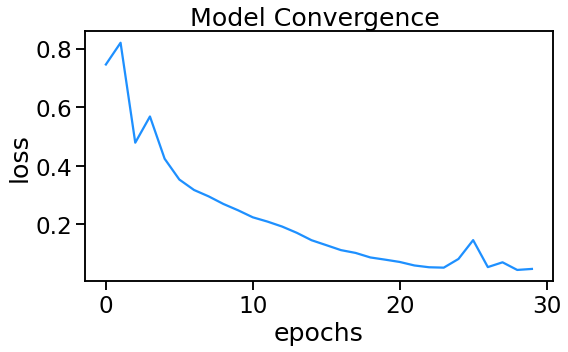

In [23]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr1)),train_loss_arr1,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.tight_layout()

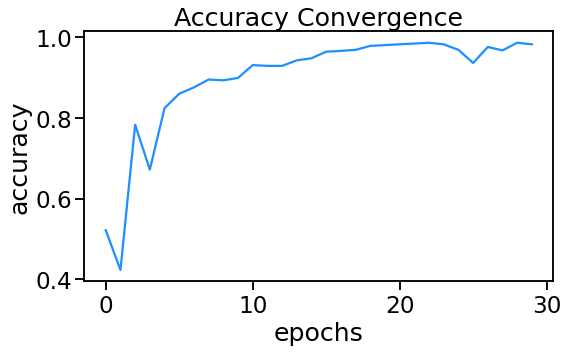

In [24]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr1)),train_acc_arr1,color='dodgerblue')
plt.title('Accuracy Convergence')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.tight_layout()

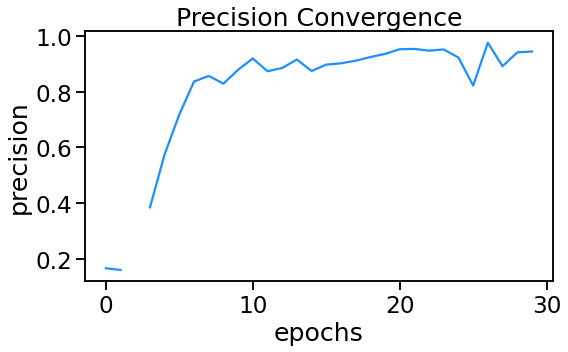

In [25]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr1)),train_prec_arr1,color='dodgerblue')
plt.title('Precision Convergence')
plt.ylabel('precision')
plt.xlabel('epochs')
plt.tight_layout()

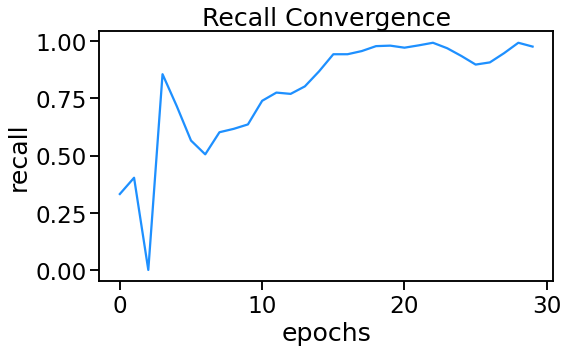

In [26]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr1)),train_recall_arr1,color='dodgerblue')
plt.title('Recall Convergence')
plt.ylabel('recall')
plt.xlabel('epochs')
plt.tight_layout()

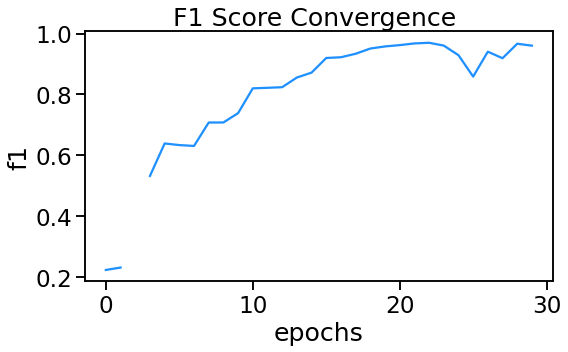

In [27]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr1)),train_f1_arr1,color='dodgerblue')
plt.title('F1 Score Convergence ')
plt.ylabel('f1')
plt.xlabel('epochs')
plt.tight_layout()

In [28]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([0,1]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([1,0])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [29]:
test_loss_arr1 = []
test_acc_arr1 = []
test_prec_arr1 = []
test_recall_arr1 = []
test_f1_arr1 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr1.append(local_loss)
  test_acc_arr1.append(_accuracy)
  test_prec_arr1.append(_precision)
  test_recall_arr1.append(_recall)
  test_f1_arr1.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.11342467367649078 . Accuracy:  0.9375 . Precision:  0.6666666666666666 . Recall:  0.6666666666666666 . F1-Score:  0.6666666666666666
Batch  1 . Loss:  0.07060468196868896 . Accuracy:  0.9375 . Precision:  0.6 . Recall:  1.0 . F1-Score:  0.7499999999999999
Batch  2 . Loss:  0.0555141344666481 . Accuracy:  0.96875 . Precision:  1.0 . Recall:  0.8571428571428571 . F1-Score:  0.9230769230769229
Batch  3 . Loss:  0.05663613602519035 . Accuracy:  0.9666666666666667 . Precision:  0.6666666666666666 . Recall:  1.0 . F1-Score:  0.8


# **45**

In [30]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=45)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [31]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 30
threshold = int(len(train_dataset1) / 10)
train_loss_arr2 = []
train_acc_arr2 = []
train_prec_arr2 = []
train_recall_arr2 = []
train_f1_arr2 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr2.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr2.append(accuracy)
  train_prec_arr2.append(precision)
  train_recall_arr2.append(recall)
  train_f1_arr2.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  30
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.912946343421936 . L-AC:  0.40625 . L-P:  0.8 . L-R:  0.18181818181818182 . L-F1:  0.2962962962962963
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.5999529361724854 . L-AC:  1.15625 . L-P:  1.7444444444444445 . L-R:  0.8901515151515151 . L-F1:  1.4750879509817494
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.4946484863758087 . L-AC:  1.84375 . L-P:  2.552136752136752 . L-R:  1.6978438228438228 . L-F1:  3.5142170920310054
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.8973405361175537 . L-AC:  2.21875 . L-P:  3.552136752136752 . L-R:  1.8282786054525184 . L-F1:  5.9282670104681685
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.5906487703323364 . L-AC:  2.875 . L-P:  4.452136752136752 . L-R:  2.494945272119185 . L-F1:  9.12610964476

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars


--------Epoch  1 Client  14 . Local Loss:  1.4505677223205566 . L-AC:  6.1875 . L-P:  nan . L-R:  5.27405176588085 . L-F1:  nan
Default client weights are used.
--------Epoch  1 Client  15 . Local Loss:  0.4726365804672241 . L-AC:  6.9375 . L-P:  nan . L-R:  6.190718432547517 . L-F1:  nan
Default client weights are used.
--------Epoch  1 Client  16 . Local Loss:  0.7347128987312317 . L-AC:  7.479166666666667 . L-P:  nan . L-R:  6.664402643073833 . L-F1:  nan
Epoch  1 . Loss:  0.8320755939930677 . Accuracy:  0.4674479166666667 . Precision:  nan . Recall:  0.4165251651921146 . F1-Score:  nan
--------Epoch  2 Client  1 . Local Loss:  0.6746773719787598 . L-AC:  0.625 . L-P:  0.9166666666666666 . L-R:  0.5 . L-F1:  0.6470588235294118
--------Epoch  2 Client  2 . Local Loss:  0.7247365117073059 . L-AC:  1.09375 . L-P:  1.7348484848484849 . L-R:  0.875 . L-F1:  1.8103389396397165
--------Epoch  2 Client  3 . Local Loss:  0.8197754621505737 . L-AC:  1.53125 . L-P:  2.484848484848485 . L-R:  1

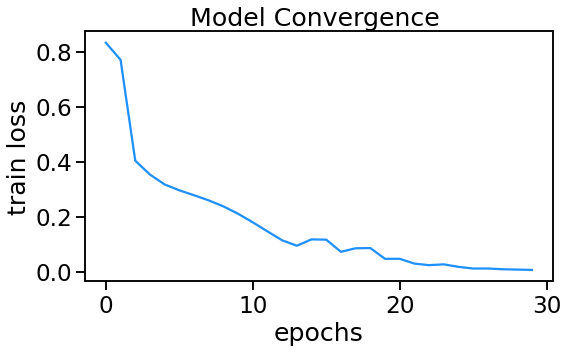

In [32]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr2)),train_loss_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

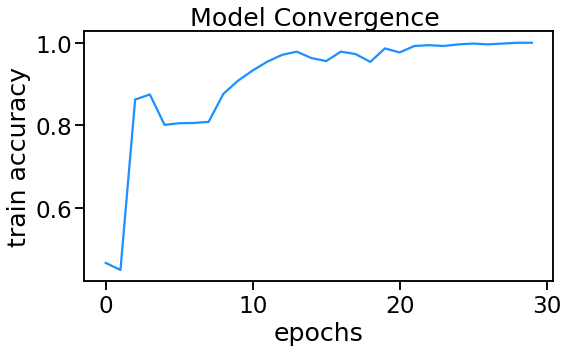

In [33]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr2)),train_acc_arr2,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

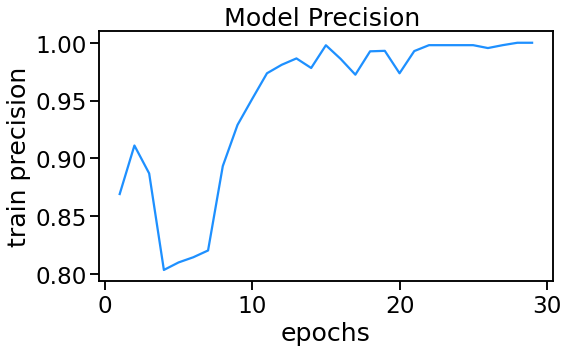

In [34]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr2)),train_prec_arr2,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

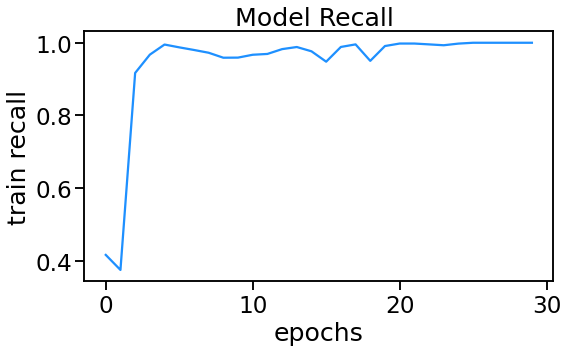

In [35]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr2)),train_recall_arr2,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

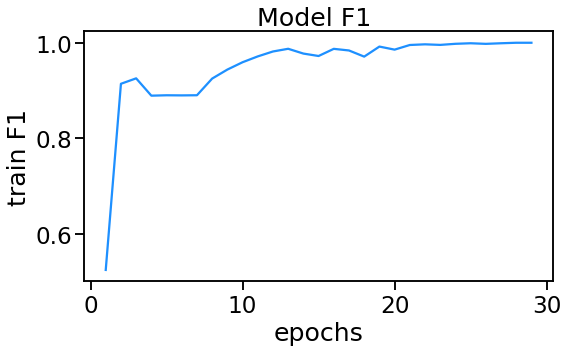

In [36]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr2)),train_f1_arr2,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [37]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([1,0]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [38]:
test_loss_arr2 = []
test_acc_arr2 = []
test_prec_arr2 = []
test_recall_arr2 = []
test_f1_arr2 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr2.append(local_loss)
  test_acc_arr2.append(_accuracy)
  test_prec_arr2.append(_precision)
  test_recall_arr2.append(_recall)
  test_f1_arr2.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.1351744532585144 . Accuracy:  0.9375 . Precision:  0.96 . Recall:  0.96 . F1-Score:  0.96
Batch  1 . Loss:  0.17650951445102692 . Accuracy:  0.96875 . Precision:  0.9615384615384616 . Recall:  1.0 . F1-Score:  0.9803921568627451
Batch  2 . Loss:  0.4007927179336548 . Accuracy:  0.90625 . Precision:  0.9285714285714286 . Recall:  0.9629629629629629 . F1-Score:  0.9454545454545454
Batch  3 . Loss:  0.0063786287792027 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0


# **50**

In [39]:
train_dataset1, test_dataset1 = train_test_split(image_dataset, test_size=0.2, random_state=50)
client_dataset1 = []
for i in range(len(train_dataset1)):
    # client_dataset.append((train_transforms(train_dataset[i][0]), torch.Tensor([class_num_covid]) if train_dataset[i][1] == class_num_covid else torch.Tensor([class_num_not_covid])))
    client_dataset1.append((train_transforms(train_dataset1[i][0]), torch.Tensor([1,0]) if train_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))

client_loader1 = torch.utils.data.DataLoader(dataset=client_dataset1, batch_size=32)

In [40]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 30
threshold = int(len(train_dataset1) / 10)
train_loss_arr3 = []
train_acc_arr3 = []
train_prec_arr3 = []
train_recall_arr3 = []
train_f1_arr3 = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader1))


for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0
  count=0
  _accuracy=0
  _precision=0
  _recall=0
  _f1=0

  clients_arr = []
  for batch_idx, (train_features, train_labels) in enumerate(client_loader1):
    clients_arr.append(FL_Client(train_features, train_labels))

  length=len(clients_arr)

  for j in range(length):
    fl_client=clients_arr[0]
    del clients_arr[0]
    if epoch != 1:
      fl_client.set_weights(copy.deepcopy(global_weights))
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy += (_tp+_tn)/(_tp+_fp+_tn+_fn)
    _precision += _tp/(_tp+_fp)
    _recall += _tp/(_tp+_fn)
    _f1 += 2/((1/_recall) + (1/_precision))
    count+=1
    fl_server.aggregate_grads(fl_client.get_gradients())
    #local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2()
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr3.append(loss)
  #accuracy = (tp+tn)/(tp+fp+tn+fn)
  #precision = tp/(tp+fp)
  #recall = tp/(tp+fn)
  #f1 = 2/((1/recall) + (1/precision))
  accuracy=_accuracy/count
  precision=_precision/count
  recall=_recall/count
  f1=2/((1/recall) + (1/precision))
  train_acc_arr3.append(accuracy)
  train_prec_arr3.append(precision)
  train_recall_arr3.append(recall)
  train_f1_arr3.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

FL_ITER:  30
NUM_CLIENTS_PER_FL_ITER:  50
Batch Idx Size:  16
Default client weights are used.
--------Epoch  1 Client  1 . Local Loss:  0.5835551023483276 . L-AC:  0.78125 . L-P:  0.9411764705882353 . L-R:  0.7272727272727273 . L-F1:  0.8205128205128205
Default client weights are used.
--------Epoch  1 Client  2 . Local Loss:  0.5919809341430664 . L-AC:  1.4375 . L-P:  1.6911764705882353 . L-R:  1.5098814229249014 . L-F1:  2.4159078560124483
Default client weights are used.
--------Epoch  1 Client  3 . Local Loss:  0.8191861510276794 . L-AC:  1.9375 . L-P:  2.5245098039215685 . L-R:  1.926548089591568 . L-F1:  4.6012712712977715
Default client weights are used.
--------Epoch  1 Client  4 . Local Loss:  0.6596538424491882 . L-AC:  2.625 . L-P:  3.370663650075415 . L-R:  2.712262375305854 . L-F1:  7.607102399200606
Default client weights are used.
--------Epoch  1 Client  5 . Local Loss:  0.669653594493866 . L-AC:  3.15625 . L-P:  4.170663650075415 . L-R:  3.3048549678984465 . L-F1:  11

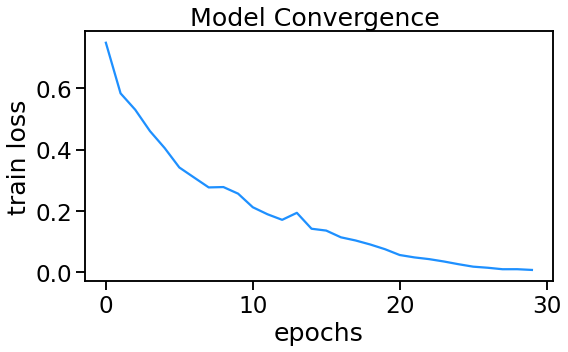

In [41]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr3)),train_loss_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

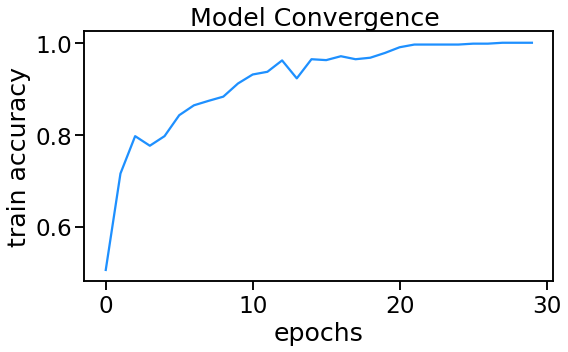

In [42]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr3)),train_acc_arr3,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

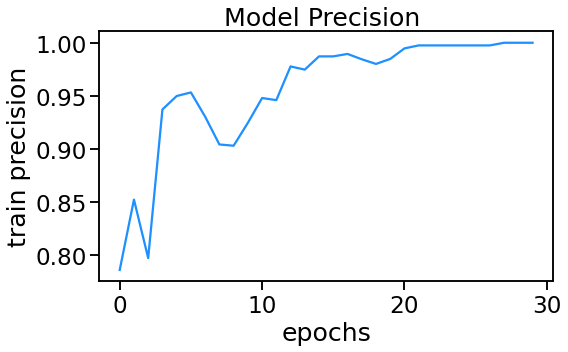

In [43]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr3)),train_prec_arr3,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

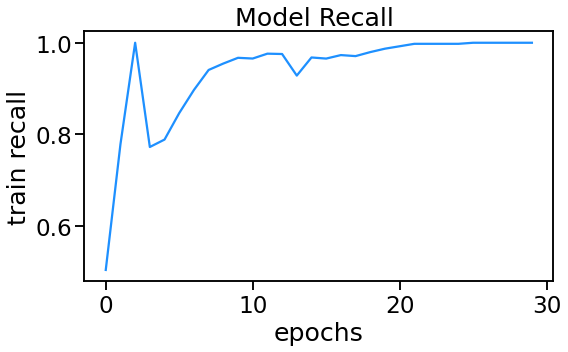

In [44]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr3)),train_recall_arr3,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

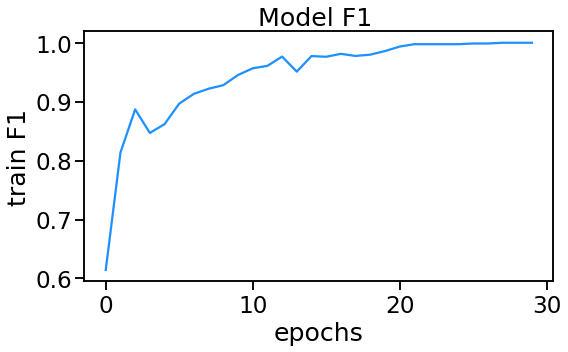

In [45]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr3)),train_f1_arr3,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [46]:
test_client_dataset1 = []
for i in range(len(test_dataset1)):
    test_client_dataset1.append((train_transforms(test_dataset1[i][0]), torch.Tensor([1,0]) if test_dataset1[i][1] == class_num_covid else torch.Tensor([0,1])))
test_client_loader1 = torch.utils.data.DataLoader(dataset=test_client_dataset1, batch_size=32)
len(test_client_loader1)

4

In [47]:
test_loss_arr3 = []
test_acc_arr3 = []
test_prec_arr3 = []
test_recall_arr3 = []
test_f1_arr3 = []

for batch_idx, (features, labels) in enumerate(test_client_loader1):
  local_loss, _tn, _fp, _fn, _tp = fl_server.train_test_model_and_get_loss(features,labels)
  _accuracy = (_tp+_tn)/(_tp+_fp+_tn+_fn)
  _precision = _tp/(_tp+_fp)
  _recall = _tp/(_tp+_fn)
  _f1 = 2/((1/_recall) + (1/_precision))
  test_loss_arr3.append(local_loss)
  test_acc_arr3.append(_accuracy)
  test_prec_arr3.append(_precision)
  test_recall_arr3.append(_recall)
  test_f1_arr3.append(_f1)
  print("Batch ", batch_idx, ". Loss: ", local_loss, ". Accuracy: ", _accuracy, ". Precision: ", _precision, ". Recall: ", _recall, ". F1-Score: ", _f1)

Batch  0 . Loss:  0.025353608652949333 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0
Batch  1 . Loss:  0.13660986721515656 . Accuracy:  0.9375 . Precision:  1.0 . Recall:  0.9259259259259259 . F1-Score:  0.9615384615384615
Batch  2 . Loss:  0.007572158705443144 . Accuracy:  1.0 . Precision:  1.0 . Recall:  1.0 . F1-Score:  1.0
Batch  3 . Loss:  0.027574051171541214 . Accuracy:  0.9666666666666667 . Precision:  1.0 . Recall:  0.9583333333333334 . F1-Score:  0.978723404255319


# **Averages**

In [48]:
import numpy as np

In [49]:
train_loss_arr_avg = np.mean(np.array([train_loss_arr1, train_loss_arr2, train_loss_arr3]), axis=0)
train_acc_arr_avg = np.mean(np.array([train_acc_arr1, train_acc_arr2, train_acc_arr3]), axis=0)
train_prec_arr_avg=np.mean(np.array([train_prec_arr1, train_prec_arr2, train_prec_arr3]), axis=0)
train_recall_arr_avg=np.mean(np.array([train_recall_arr1, train_recall_arr2, train_recall_arr3]), axis=0)
train_f1_arr_avg=np.mean(np.array([train_f1_arr1, train_f1_arr2, train_f1_arr3]), axis=0)

In [50]:
print(train_loss_arr_avg[-1])
print(train_acc_arr_avg[-1])
print(train_prec_arr_avg[-1])
print(train_recall_arr_avg[-1])
print(train_f1_arr_avg[-1])

0.02034601407406929
0.994140625
0.9813988095238096
0.9923363095238096
0.9867741580773125


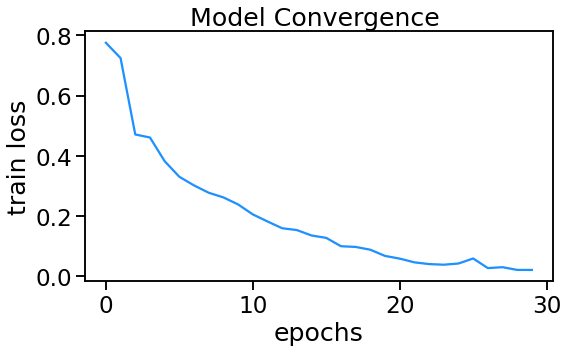

In [51]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_loss_arr_avg)),train_loss_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train loss')
plt.xlabel('epochs')
plt.tight_layout()

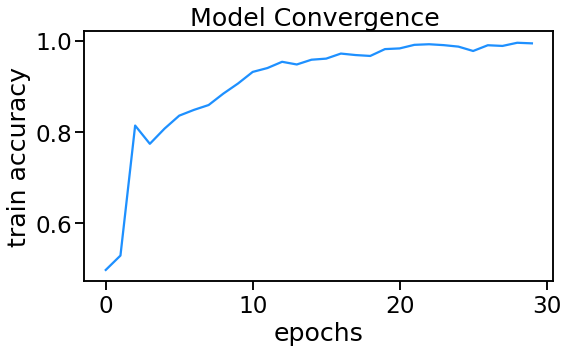

In [52]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_acc_arr_avg)),train_acc_arr_avg,color='dodgerblue')
plt.title('Model Convergence ')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.tight_layout()

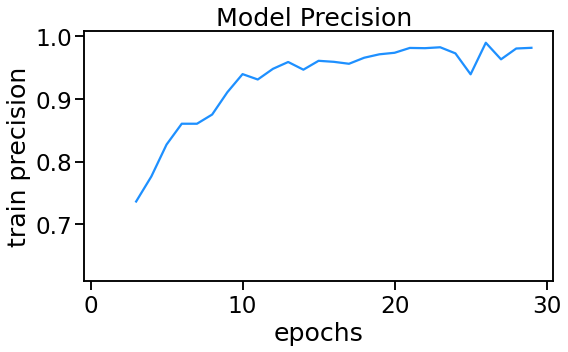

In [53]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_prec_arr_avg)),train_prec_arr_avg,color='dodgerblue')
plt.title('Model Precision ')
plt.ylabel('train precision')
plt.xlabel('epochs')
plt.tight_layout()

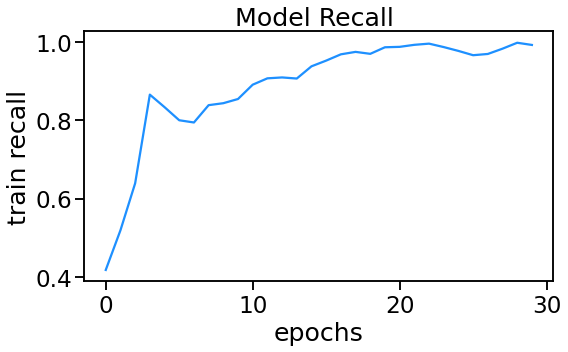

In [54]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_recall_arr_avg)),train_recall_arr_avg,color='dodgerblue')
plt.title('Model Recall ')
plt.ylabel('train recall')
plt.xlabel('epochs')
plt.tight_layout()

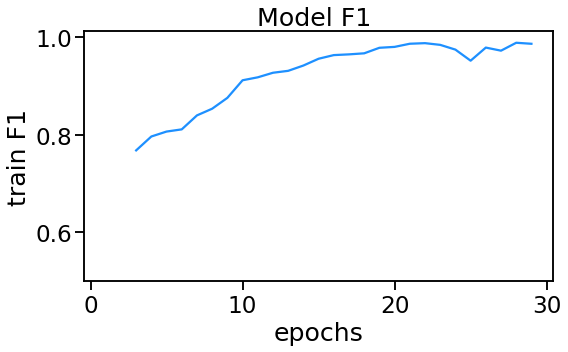

In [55]:
plt.figure(figsize=(8,5))
plt.plot(range(len(train_f1_arr_avg)),train_f1_arr_avg,color='dodgerblue')
plt.title('Model F1 ')
plt.ylabel('train F1')
plt.xlabel('epochs')
plt.tight_layout()

In [56]:
print("Batch 0", ". Loss: ", (test_loss_arr1[0]+test_loss_arr2[0]+test_loss_arr3[0])/3, ". Accuracy: ", (test_acc_arr1[0]+test_acc_arr2[0]+test_acc_arr3[0])/3, ". Precision: ", (test_prec_arr1[0]+test_prec_arr2[0]+test_prec_arr3[0])/3, ". Recall: ", (test_recall_arr1[0]+test_recall_arr2[0]+test_recall_arr3[0])/3, ". F1-Score: ",(test_f1_arr1[0]+test_f1_arr2[0]+test_f1_arr3[0])/3)
print("Batch 1", ". Loss: ", (test_loss_arr1[1]+test_loss_arr2[1]+test_loss_arr3[1])/3, ". Accuracy: ", (test_acc_arr1[1]+test_acc_arr2[1]+test_acc_arr3[1])/3, ". Precision: ", (test_prec_arr1[1]+test_prec_arr2[1]+test_prec_arr3[1])/3, ". Recall: ", (test_recall_arr1[1]+test_recall_arr2[1]+test_recall_arr3[1])/3, ". F1-Score: ",(test_f1_arr1[1]+test_f1_arr2[1]+test_f1_arr3[1])/3)
print("Batch 2", ". Loss: ", (test_loss_arr1[2]+test_loss_arr2[2]+test_loss_arr3[2])/3, ". Accuracy: ", (test_acc_arr1[2]+test_acc_arr2[2]+test_acc_arr3[2])/3, ". Precision: ", (test_prec_arr1[2]+test_prec_arr2[2]+test_prec_arr3[2])/3, ". Recall: ", (test_recall_arr1[2]+test_recall_arr2[2]+test_recall_arr3[2])/3, ". F1-Score: ",(test_f1_arr1[2]+test_f1_arr2[2]+test_f1_arr3[2])/3)
print("Batch 3", ". Loss: ", (test_loss_arr1[3]+test_loss_arr2[3]+test_loss_arr3[3])/3, ". Accuracy: ", (test_acc_arr1[3]+test_acc_arr2[3]+test_acc_arr3[3])/3, ". Precision: ", (test_prec_arr1[3]+test_prec_arr2[3]+test_prec_arr3[3])/3, ". Recall: ", (test_recall_arr1[3]+test_recall_arr2[3]+test_recall_arr3[3])/3, ". F1-Score: ",(test_f1_arr1[3]+test_f1_arr2[3]+test_f1_arr3[3])/3)

Batch 0 . Loss:  0.09131757852931817 . Accuracy:  0.9583333333333334 . Precision:  0.8755555555555555 . Recall:  0.8755555555555555 . F1-Score:  0.8755555555555555
Batch 1 . Loss:  0.12790802121162415 . Accuracy:  0.9479166666666666 . Precision:  0.8538461538461538 . Recall:  0.9753086419753086 . F1-Score:  0.8973102061337355
Batch 2 . Loss:  0.15462633703524867 . Accuracy:  0.9583333333333334 . Precision:  0.9761904761904763 . Recall:  0.9400352733686067 . F1-Score:  0.956177156177156
Batch 3 . Loss:  0.03019627199197809 . Accuracy:  0.9777777777777779 . Precision:  0.8888888888888888 . Recall:  0.9861111111111112 . F1-Score:  0.926241134751773


In [57]:
print("Test", ". Loss: ", (test_loss_arr1[0]+test_loss_arr2[0]+test_loss_arr3[0]+test_loss_arr1[1]+test_loss_arr2[1]+test_loss_arr3[1]+test_loss_arr1[2]+test_loss_arr2[2]+test_loss_arr3[2]+test_loss_arr1[3]+test_loss_arr2[3]+test_loss_arr3[3])/12, ". Accuracy: ", (test_acc_arr1[0]+test_acc_arr2[0]+test_acc_arr3[0]+test_acc_arr1[1]+test_acc_arr2[1]+test_acc_arr3[1]+test_acc_arr1[2]+test_acc_arr2[2]+test_acc_arr3[2]+test_acc_arr1[3]+test_acc_arr2[3]+test_acc_arr3[3])/12, ". Precision: ", (test_prec_arr1[0]+test_prec_arr2[0]+test_prec_arr3[0]+test_prec_arr1[1]+test_prec_arr2[1]+test_prec_arr3[1]+test_prec_arr1[2]+test_prec_arr2[2]+test_prec_arr3[2]+test_prec_arr1[3]+test_prec_arr2[3]+test_prec_arr3[3])/12, ". Recall: ", (test_recall_arr1[0]+test_recall_arr2[0]+test_recall_arr3[0]+test_recall_arr1[1]+test_recall_arr2[1]+test_recall_arr3[1]+test_recall_arr1[2]+test_recall_arr2[2]+test_recall_arr3[2]+test_recall_arr1[3]+test_recall_arr2[3]+test_recall_arr3[3])/12, ". F1-Score: ",(test_f1_arr1[0]+test_f1_arr2[0]+test_f1_arr3[0]+test_f1_arr1[1]+test_f1_arr2[1]+test_f1_arr3[1]+test_f1_arr1[2]+test_f1_arr2[2]+test_f1_arr3[2]+test_f1_arr1[3]+test_f1_arr2[3]+test_f1_arr3[3])/12)


Test . Loss:  0.10101205219204228 . Accuracy:  0.9605902777777778 . Precision:  0.8986202686202686 . Recall:  0.9442526455026455 . F1-Score:  0.9138210131545551


In [ ]:
# TESTING DATA ABOVE #

In [ ]:
# NUM OF CLIENTS = TOTAL IMAGES / BATCH SIZE
fl_server = FL_Server()
fl_iter = 50
threshold = int(len(train_dataset) / 10)
train_loss_arr = []
train_acc_arr = []
train_prec_arr = []
train_recall_arr = []
train_f1_arr = []

print("FL_ITER: ", fl_iter)
print("NUM_CLIENTS_PER_FL_ITER: ", threshold)
print("Batch Idx Size: ", len(client_loader))

clients_arr = []
for batch_idx, (train_features, train_labels) in enumerate(client_loader):
  clients_arr.append(FL_Client(train_features, train_labels))

for epoch in range(1, fl_iter + 1):
  global_weights = fl_server.get_weights()
  local_gradients = []
  net_loss = 0
  net_i = 0
  tn = 0
  fp = 0
  fn = 0
  tp = 0

  for fl_client in clients_arr:
    if epoch != 1:
      fl_client.set_weights(global_weights)
    else:
      print("Default client weights are used.")
    local_loss, _tn, _fp, _fn, _tp = fl_client.train_model()
    net_loss += local_loss
    net_i += 1
    tn += _tn
    fp += _fp
    fn += _fn
    tp += _tp
    _accuracy = (_tp+_fp)/(_tp+_fp+_tn+_fn)
    _precision = _tp/(_tp+_fp)
    _recall = _tp/(_tp+_fn)
    _f1 = 2/((1/_recall) + (1/_precision))
    local_gradients.append(fl_client.get_gradients())
    print("--------Epoch ",epoch,"Client ", net_i,". Local Loss: ", local_loss, ". L-AC: ", _accuracy, ". L-P: ", _precision, ". L-R: ", _recall, ". L-F1: ", _f1)
    # if _accuracy == 0:
    #   print("--------Epoch ",epoch,"Client ", net_i,". TN: ", _tn, ". FP: ", _fp, ". FN: ", _fn, ". TP: ", _tp)

  fl_server.update_grad_v2(local_gradients)
  fl_server.train_model()

  loss = net_loss / net_i
  train_loss_arr.append(loss)
  accuracy = (tp+fp)/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2/((1/recall) + (1/precision))
  train_acc_arr.append(accuracy)
  train_prec_arr.append(precision)
  train_recall_arr.append(recall)
  train_f1_arr.append(f1)

  print("Epoch ", epoch, ". Loss: ", loss, ". Accuracy: ", accuracy, ". Precision: ", precision, ". Recall: ", recall, ". F1-Score: ", f1)

In [ ]:
len(client_loader)

In [ ]:
#MACHINE LEARNING CODE BELOW

In [ ]:
train_loss_arr = []
ae = AE()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ae.parameters(), lr = 3e-3)
ml_iter = 10
for i in range(0, ml_iter + 1):
  local_loss = 0
  count = 0
  for batch_idx, (train_features, train_labels) in enumerate(client_loader):
    optimizer.zero_grad()
    output = ae(train_features)
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()
    local_loss  = local_loss + loss.item()
    count = count + 1
    # if(batch_idx > 5):
    #   break
  epoch_loss = local_loss / count
  train_loss_arr.append(epoch_loss)
  print(i,". Loss: ", epoch_loss)

In [ ]:
train_loss_arr = []
ae = AE()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ae.parameters(), lr = 3e-3)
ml_iter = 10

#SET DEFAULT WEIGHTS TO ZERO
for layer, param in ae.named_parameters():
  param.data = torch.zeros(param.shape)

for i in range(0, ml_iter + 1):
  local_loss = 0
  count = 0
  for batch_idx, (train_features, train_labels) in enumerate(client_loader):
    optimizer.zero_grad()
    output = ae(train_features)
    loss = criterion(output, train_labels)
    loss.backward()
    optimizer.step()
    local_loss  = local_loss + loss.item()
    count = count + 1
    # if(batch_idx > 5):
    #   break
    print("--------Epoch ",i,"Batch ", batch_idx,". Local Loss: ", loss.item())
  epoch_loss = local_loss / count
  train_loss_arr.append(epoch_loss)
  print("Epoch ",i,". Loss: ", epoch_loss)